# Calibrating Jensen Shannon

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so


from distribution_diff import jensen_shannon_divergence, DistCalculator

## Generate the reference distribution

Gaussian, mean 0, standard deviation 1

In [2]:
rng = np.random.default_rng(seed=20230905)
reference_dist = rng.normal(loc=0, scale=1, size=1000)


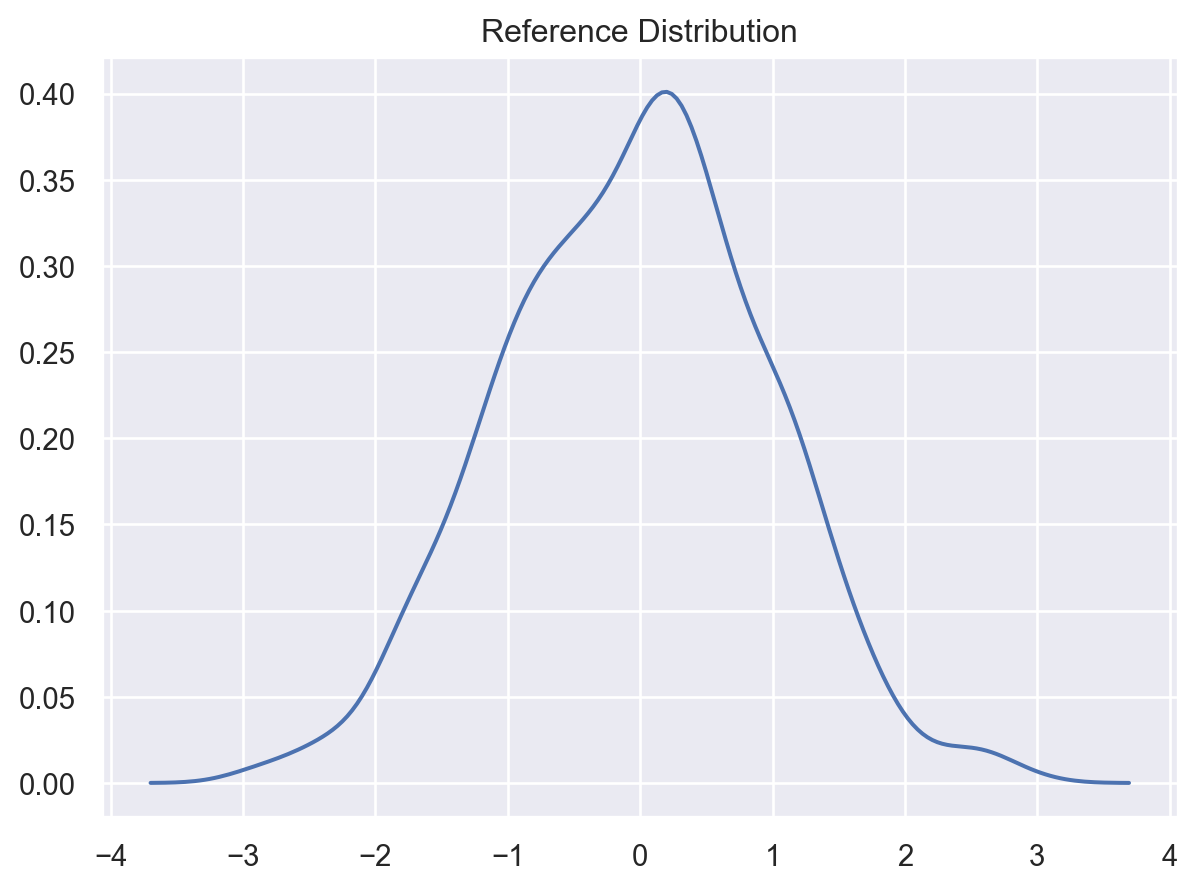

In [3]:
p = so.Plot(x=reference_dist).add(so.Line(), so.KDE())
p.label(title="Reference Distribution")

In [4]:
# create a PSI calculator with this reference distribution
psiCalc = DistCalculator(reference_dist)

## Bootstrap sampling

Both Jensen-Shannon and PSI will be measured with decile binning.

In [5]:
niters = 1000
jsvec = []
psivec = []

for i in range(niters):
    bsample = rng.choice(reference_dist, size=len(reference_dist), replace=True)
    jsvec.append(jensen_shannon_divergence(bsample, reference_dist))
    psivec.append(psiCalc.PSI(bsample))

flist = [
    pd.DataFrame({
        'div': jsvec,
        'type': 'Jensen-Shannon'
    }),
    pd.DataFrame({
        'div': psivec,
        'type': 'PSI'
    }),
]

pframe = pd.concat(flist)
pframe


,div,type
0,0.001579,Jensen-Shannon
1,0.001959,Jensen-Shannon
2,0.001040,Jensen-Shannon
3,0.005361,Jensen-Shannon
4,0.001679,Jensen-Shannon
...,...,...
995,0.006392,PSI
996,0.009463,PSI
997,0.004047,PSI
998,0.002705,PSI


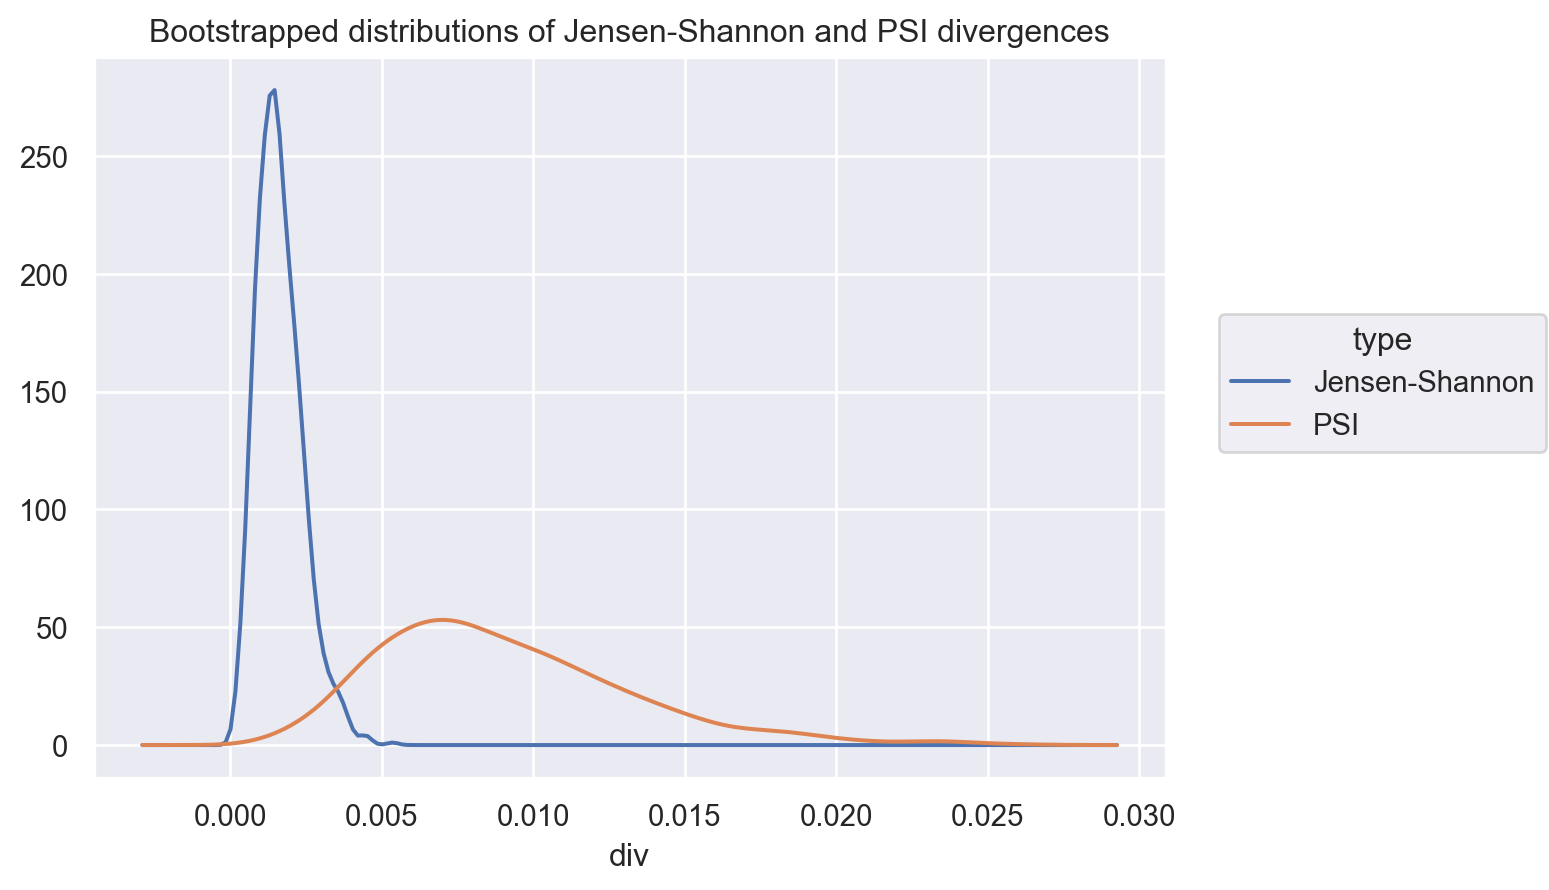

In [6]:
p = so.Plot(pframe, "div", color="type").add(so.Line(), so.KDE())
p.label(title='Bootstrapped distributions of Jensen-Shannon and PSI divergences')

## Distribution drift

We'll be measuring increasing variance (but we'll hold the mean the same)

In [7]:
def generate_comparison(newscale, niter=10):
    jsvec = []
    psivec = []
    for i in range(niter):
        bsample = rng.normal(loc=0, scale=newscale, size=1000)
        jsvec.append(jensen_shannon_divergence(bsample, reference_dist))
        psivec.append(psiCalc.PSI(bsample))

    ns = f'{newscale:.2f}'
    flist = [
        pd.DataFrame({
            'scale': newscale,
            'div': jsvec,
            'type': 'Jensen-Shannon'
        }),
        pd.DataFrame({
            'scale': newscale,
            'div': psivec,
            'type': 'PSI'
        }),
    ]

    return(pd.concat(flist))

def minmax(v):
    return np.array([v.min(), v.max()])

In [10]:
newscales = np.linspace(1, 2, num=20, endpoint=True)
flist = [generate_comparison(ns) for ns in newscales]
pframe = pd.concat(flist)
pframe



,scale,div,type
0,1.0,0.004197,Jensen-Shannon
1,1.0,0.005076,Jensen-Shannon
2,1.0,0.002124,Jensen-Shannon
3,1.0,0.005830,Jensen-Shannon
4,1.0,0.004568,Jensen-Shannon
...,...,...,...
5,2.0,0.503845,PSI
6,2.0,0.492617,PSI
7,2.0,0.502127,PSI
8,2.0,0.541353,PSI


In [11]:

p = (so.Plot(pframe, x="scale", y="div", color="type")
       .add(so.Dots(), so.Agg("median"))
       .add(so.Range(), so.Est(errorbar=minmax))
       .label(title='Divergence values as scale increases')
)


# p.show()


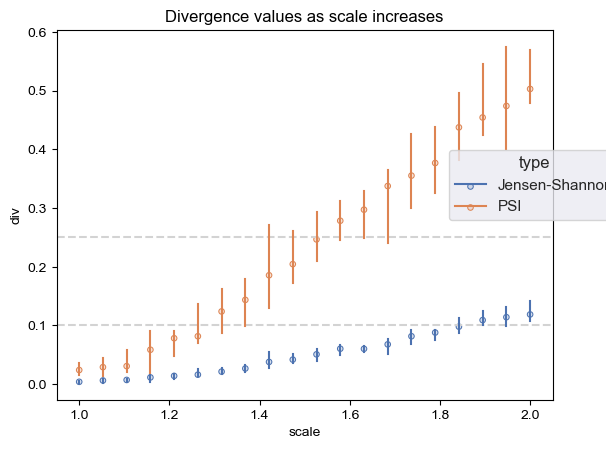

In [12]:
fig, ax = plt.subplots()
plt.axhline(y=0.1, color='lightgray', linestyle='--')
plt.axhline(y=0.25, color='lightgray', linestyle='--')
p.on(ax).show()

In [13]:
pframe

,scale,div,type
0,1.0,0.004197,Jensen-Shannon
1,1.0,0.005076,Jensen-Shannon
2,1.0,0.002124,Jensen-Shannon
3,1.0,0.005830,Jensen-Shannon
4,1.0,0.004568,Jensen-Shannon
...,...,...,...
5,2.0,0.503845,PSI
6,2.0,0.492617,PSI
7,2.0,0.502127,PSI
8,2.0,0.541353,PSI


In [14]:
sframe = (
    pframe
        .groupby(["scale", "type"])
        .mean()
        .reset_index(drop=False, inplace=False)
)
s_j = (
    sframe
        .loc[sframe["type"] == "Jensen-Shannon", :]
        .reset_index(drop=True, inplace=False)
        .rename(columns={"div": "Jensen-Shannon divergence"})
)
del s_j["type"]
s_p = (
    sframe
        .loc[sframe["type"] == "PSI", :]
        .reset_index(drop=True, inplace=False)
        .rename(columns={"div": "PSI divergence"})
)
del s_p["type"]
splot = (
    s_j
        .merge(
            s_p,
            on=["scale"]
        )
)



splot['PSI heuristic'] = np.where(splot['PSI divergence'] < 0.1, 'not very different',
                                   np.where(splot['PSI divergence'] > 0.25, 'very different', 'somewhat different'))
splot

,scale,Jensen-Shannon divergence,PSI divergence,PSI heuristic
0,1.000000,0.004141,0.023906,not very different
1,1.052632,0.005968,0.029051,not very different
2,1.105263,0.006999,0.033821,not very different
3,1.157895,0.010873,0.057658,not very different
4,1.210526,0.013604,0.073469,not very different
5,1.263158,0.017235,0.090396,not very different
6,1.315789,0.022531,0.123769,somewhat different
7,1.368421,0.026422,0.141247,somewhat different
8,1.421053,0.037868,0.190790,somewhat different
9,1.473684,0.042471,0.211126,somewhat different


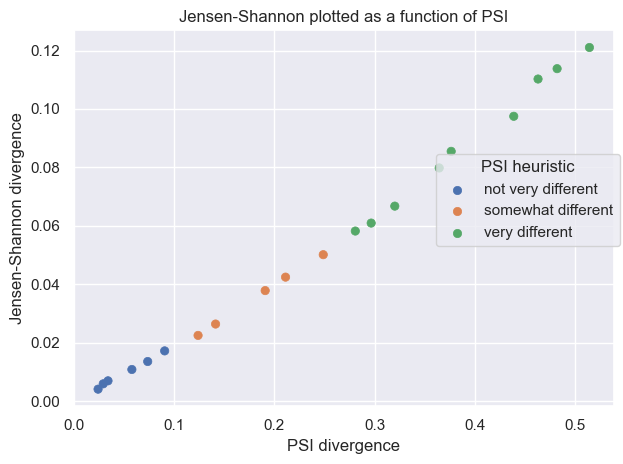

In [15]:

p = (so.Plot(splot, x="PSI divergence", y="Jensen-Shannon divergence", color="PSI heuristic")
       .add(so.Dot())
       .label(title='Jensen-Shannon plotted as a function of PSI')
)

p.show()


## Fit the relationship

And yes, I know I should probably do this with `statsmodels`, but sklearn is easier to use, and I'm not concerned with significances (given that the relationship is quite clear).

In [16]:
from sklearn.linear_model import LinearRegression

# use all the data, not the aggregated data
# data should be in the same order

pf1 = pframe.loc[pframe['type']=='Jensen-Shannon', :].reset_index(drop=True, inplace=False)
pf2 = pframe.loc[pframe['type']=='PSI', :].reset_index(drop=True, inplace=False)

pf1.rename(columns={'div': 'Jensen-Shannon'}, inplace=True)
pf1.drop(columns=['type'], inplace=True)
pf2.rename(columns={'div': 'PSI'}, inplace=True)
pf2.drop(columns=['type'], inplace=True)

[pf1, pf2]

lm = LinearRegression()
lm.fit(pf2.loc[:, ['PSI']], pf1['Jensen-Shannon'])

LinearRegression()

In [17]:
[lm.intercept_, lm.coef_]

[-0.004126285482173413, array([0.23407312])]

In [18]:
pf2['Jensen-Shannon'] = pf1['Jensen-Shannon']
# pf2['JS-predicted'] = lm.predict(pf2.loc[:, ['PSI']])
pf2pred = pd.DataFrame({
    'PSI': pf2['PSI'],
    'Jensen-Shannon': lm.predict(pf2.loc[:, ['PSI']])
})


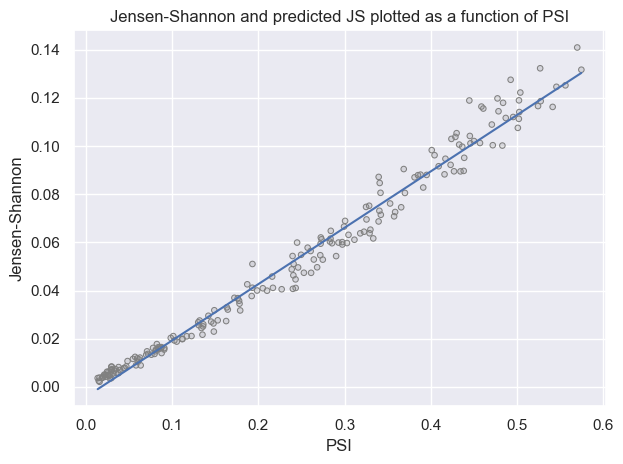

In [19]:
# ok, so this is more awkward than ggplot2.

p = (so.Plot(pf2, x="PSI", y="Jensen-Shannon")
       .add(so.Dots(color='gray'))
       .add(so.Line(), data=pf2pred)
      .label(title='Jensen-Shannon and predicted JS plotted as a function of PSI')
)

p.show()


So one can say (at least for this problem, in this range) that the Jensen Shannon divergence is approximately 0.236 PSI. The relationship likely will vary with the distribution (see `test_cnc_anomaly.ipynb` for another example.)

In [20]:
tmat = pd.DataFrame({'PSI': [0.1, 0.25]})
js_thresh = lm.predict(tmat)

print(f'''
Heuristic thresholds for Jensen-Shannon divergence:
* over {js_thresh[0]:.2f}: "somewhat different"
* over {js_thresh[1]:.2f}: "very different"
''')


Heuristic thresholds for Jensen-Shannon divergence:
* over 0.02: "somewhat different"
* over 0.05: "very different"

